In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor,InterpolationMode
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, classification_report
from tqdm.auto import tqdm
from collections import Counter

In [2]:
# set device by checking if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# set seed for reproducibilty
SEED = 50

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# root directory where the food-11 zip file is located
root_dir = 'drive/MyDrive/'

Mounted at /content/drive


**DATA PREPROCESSING AND VISUALIZATION**

In [5]:
# extract the food-11 zip file
with zipfile.ZipFile(root_dir + 'food-11.zip', 'r') as zip_ref:
    zip_ref.extractall('food-11/')

In [6]:
# transformations to be applied on an image
image_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # resize the image
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # apply data augmentation
    transforms.ToTensor(), # convert the image into a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize the image
])

In [7]:
# create datasets
train_data = datasets.ImageFolder('food-11/training/', transform=image_transform)
val_data = datasets.ImageFolder('food-11/validation/', transform=image_transform)
test_data = datasets.ImageFolder('food-11/evaluation/', transform=image_transform)

In [8]:
class_names = train_data.classes
print(class_names)

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


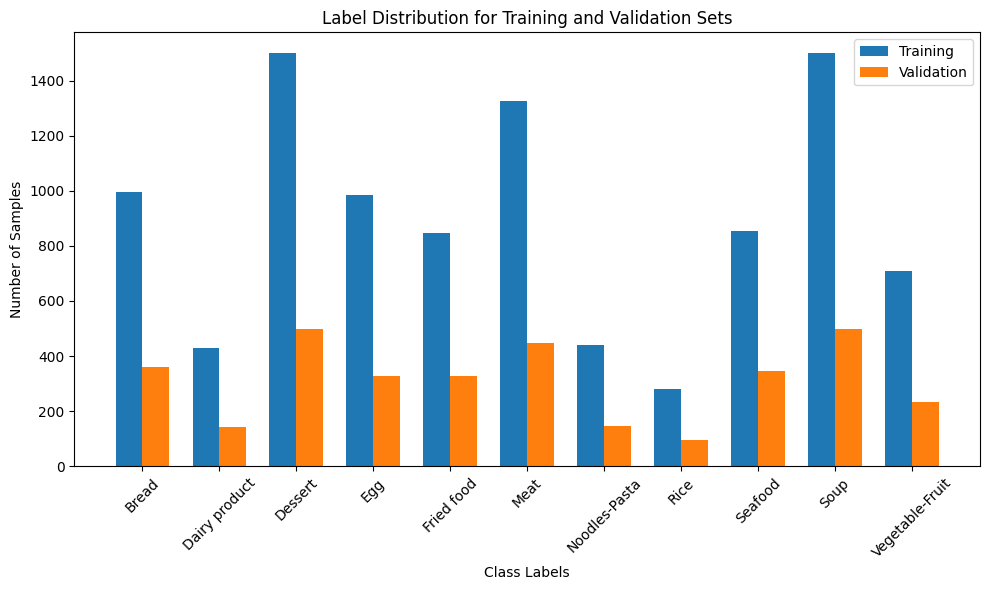

In [9]:
# display histogram of distribution of labels in training and validation set
train_labels = [class_names[label] for _, label in train_data.imgs]
val_labels = [class_names[label] for _, label in val_data.imgs]

train_counter = Counter(train_labels)
val_counter = Counter(val_labels)

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(class_names))

plt.bar(index, list(train_counter.values()), bar_width, label='Training')
plt.bar(index + bar_width, list(val_counter.values()), bar_width, label='Validation')

plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Label Distribution for Training and Validation Sets')
plt.xticks(index + bar_width / 2, class_names, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

9866
3430
3347


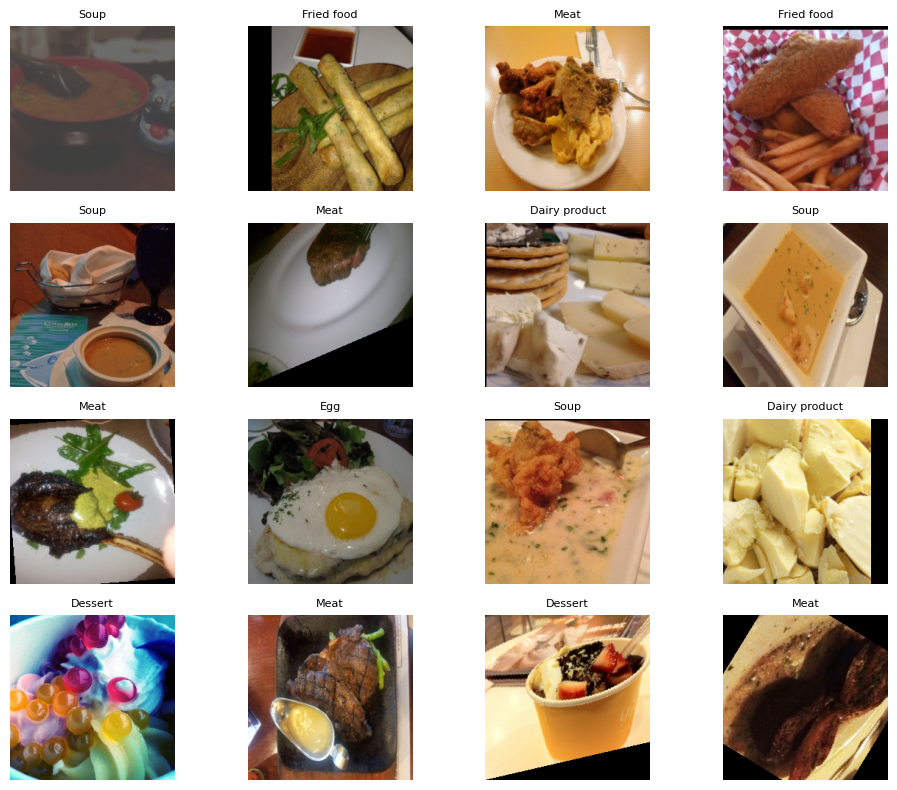

In [11]:
# function to unnormalize the images
def unnormalize(image):
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    return image

# plot some of the training images
plt.figure(figsize=(10, 8))

for i in range(16):
    image, label = train_data[random.randint(0, len(train_data))]
    image = unnormalize(image)
    image_permute = image.permute(1, 2, 0)

    plt.subplot(4, 4, i + 1)
    plt.imshow(image_permute)
    plt.axis("off")
    plt.title(train_data.classes[label], fontsize=8)

plt.tight_layout()
plt.show()

In [12]:
BATCH_SIZE = 64

# convert datasets to dataloaders
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

val_dataloader = DataLoader(val_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [13]:
# get a batch of images and labels from the dataloader
train_images,train_labels = next(iter(train_dataloader))
print(train_images.shape)
print(train_labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


**TRAINING**

In [14]:
# function to calculate accuracy
def accuracy(labels,preds):
    correct = torch.eq(labels,preds).sum().item()
    acc = (correct/len(labels))*100
    return acc

In [15]:
# function to train the model
def train(model, dataloader, criterion, optimizer):
    # set the model to training mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (images, labels) in enumerate(dataloader):
        # send data to target device
        images, labels = images.to(device), labels.to(device)

        # pass the data to the model and get model outputs
        logits = model(images)

        # calulate the loss
        loss = criterion(logits, labels)
        train_loss += loss.item()

        # clear the gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # update the model parameters
        optimizer.step()

        # calculate the accuracy
        train_acc = train_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    train_loss = train_loss / len(dataloader)

    # calculate the mean accuracy
    train_acc = train_acc / len(dataloader)

    return train_loss,train_acc

In [16]:
# function to test the model on validation set while training
# to measure the loss and accuracy
def test(model, dataloader, criterion):
    # set the model to evaluation mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            # send data to target device
            images, labels = images.to(device), labels.to(device)

            # pass the data to the model and get model outputs
            logits = model(images)

            # calulate the loss
            loss = criterion(logits, labels)
            test_loss += loss.item()

            # calculate the accuracy
            test_acc = test_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    test_loss = test_loss / len(dataloader)

    # calculate the mean accuracy
    test_acc = test_acc / len(dataloader)

    return test_loss,test_acc

In [17]:
# function to evaluate the model after training
# and measure various performance metrics
def evaluate(model, dataloader, class_names):
    # set the model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []
    all_top5_preds = []

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            # get predictions from the model
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            # get top 5 predictions
            top5_preds = torch.topk(logits, k=5, dim=1).indices

            # accumulate predictions and true labels
            all_preds = all_preds + preds.cpu().tolist()
            all_labels = all_labels + labels.cpu().tolist()
            all_top5_preds = all_top5_preds + top5_preds.cpu().tolist()

    # convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_top5_preds = np.array(all_top5_preds)

    # get the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)

    # calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)

    # calculate top-5 accuracy
    top5_correct = 0
    for i in range(len(all_labels)):
        if all_labels[i] in all_top5_preds[i]:
            top5_correct += 1
    top5_accuracy = top5_correct / len(all_labels)

    # calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # print metrics
    print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
    print(f"Top-5 Accuracy: {top5_accuracy*100:.2f}%")
    print(f"Balanced Accuracy: {balanced_accuracy*100:.2f}%")
    print("\nPer-Class Accuracies:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_accuracy[i]*100:.2f}%")

    return balanced_accuracy

In [18]:
# function to plot the loss curves
def plot_curves(results):
    colors = ['b','g','r','y']

    # plot training losses for all models
    plt.figure(figsize=(8, 6))
    for i,(model, losses) in enumerate(results.items()):
        epochs = range(1, len(losses['train_loss']) + 1)
        plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
        plt.plot(epochs, losses['train_loss'], label=f"{model[0]} Optimizer with LR {model[1]}", color=colors[i], linestyle='-', linewidth=2, marker='D', markersize=5)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # plot validation losses for all models
    plt.figure(figsize=(8, 6))
    for i,(model, losses) in enumerate(results.items()):
        epochs = range(1, len(losses['val_loss']) + 1)
        plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
        plt.plot(epochs, losses['val_loss'], label=f"{model[0]} with LR {model[1]}", color=colors[i], linestyle='-', linewidth=2, marker='D', markersize=5)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

In [19]:
best_model = None
best_model_name = ""
best_optim = ""
best_lr = None
best_balanced_accuracy = 0

**BASELINE**

In [20]:
epochs = 6

results = {}

In [21]:
class Baseline(nn.Module):
    def __init__(self, num_classes):
        super(Baseline, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [22]:
# baseline model
model = Baseline(len(train_data.classes)).to(device)

In [23]:
# loss function
criterion = nn.CrossEntropyLoss()

In [24]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
results[("Adam",0.001)] = {
    "train_loss": [],
    "val_loss": []
}

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 2.4545 | Training Accuracy: 19.88% | Validation Loss: 2.2395 | Validation Accuracy: 19.85%
Epoch: 2 | Training Loss: 2.1726 | Training Accuracy: 22.61% | Validation Loss: 2.1542 | Validation Accuracy: 23.47%
Epoch: 3 | Training Loss: 2.1150 | Training Accuracy: 25.43% | Validation Loss: 2.1367 | Validation Accuracy: 24.52%
Epoch: 4 | Training Loss: 2.0205 | Training Accuracy: 29.22% | Validation Loss: 1.9994 | Validation Accuracy: 29.94%
Epoch: 5 | Training Loss: 1.9119 | Training Accuracy: 33.78% | Validation Loss: 1.9587 | Validation Accuracy: 28.91%
Epoch: 6 | Training Loss: 1.8217 | Training Accuracy: 36.92% | Validation Loss: 1.8866 | Validation Accuracy: 34.17%


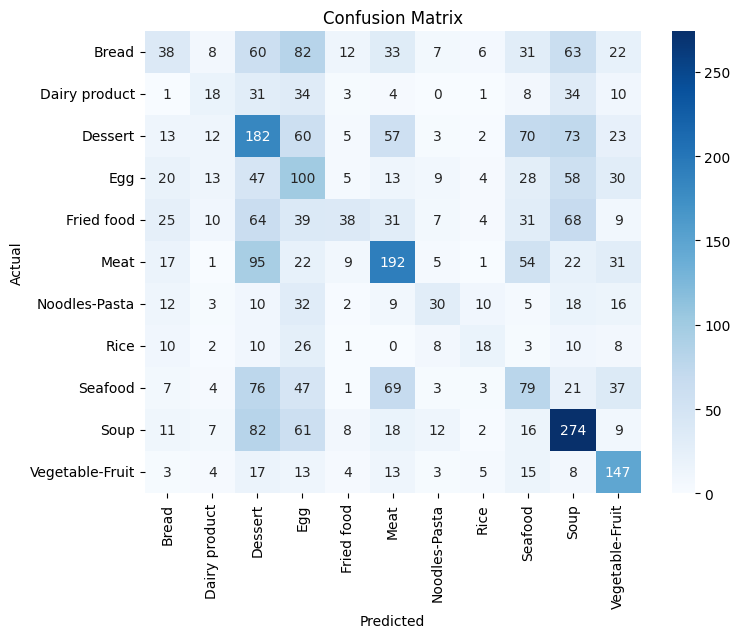

Overall Accuracy: 32.54%
Top-5 Accuracy: 81.43%
Balanced Accuracy: 29.50%

Per-Class Accuracies:
Bread: 10.50%
Dairy product: 12.50%
Dessert: 36.40%
Egg: 30.58%
Fried food: 11.66%
Meat: 42.76%
Noodles-Pasta: 20.41%
Rice: 18.75%
Seafood: 22.77%
Soup: 54.80%
Vegetable-Fruit: 63.36%


In [26]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
    val_loss,val_acc = test(model,val_dataloader,criterion)

    print(f"Epoch: {epoch+1} | Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}% | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

    # update the results dictionary
    results[("Adam",0.001)]["train_loss"].append(train_loss)
    results[("Adam",0.001)]["val_loss"].append(val_loss)

# evaluate the model on the validation set
balanced_accuracy = evaluate(model, val_dataloader, class_names)

if balanced_accuracy > best_balanced_accuracy:
    best_balanced_accuracy = balanced_accuracy
    best_model = model
    best_optim = "Adam"
    best_lr = 0.001
    best_model_name = "Baseline"

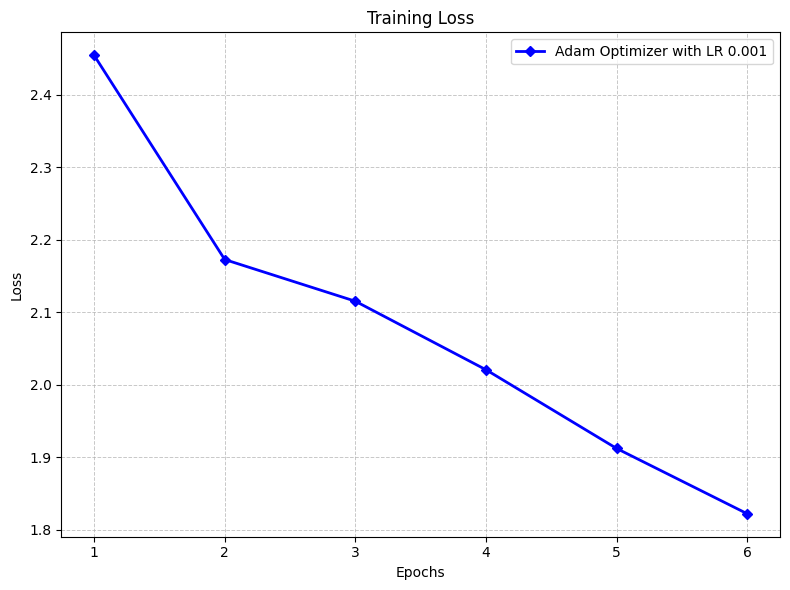

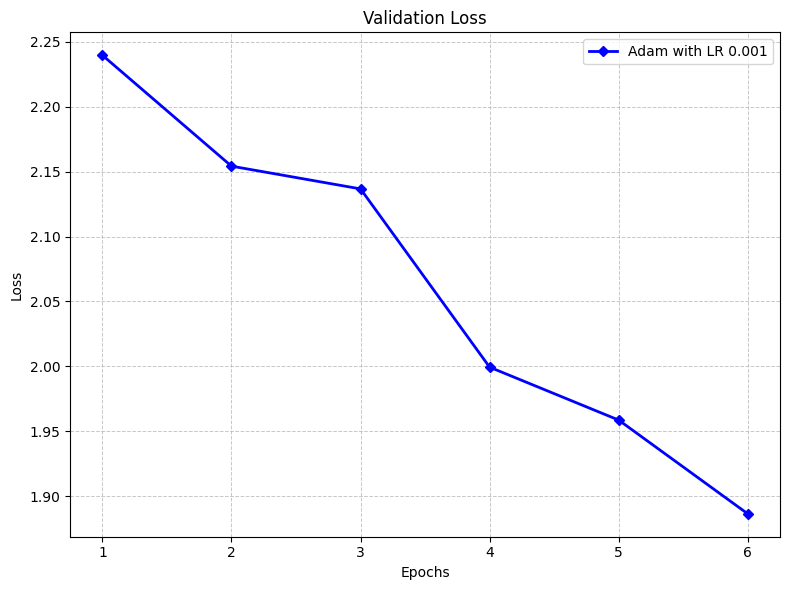

In [27]:
# plot the loss curves
plot_curves(results)

**ALEXNET**

In [28]:
epochs = 6

results = {}


Training with Adam optimizer and learning-rate of 0.001



Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 168MB/s]


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 2.1662 | Training Accuracy: 42.98% | Validation Loss: 1.3234 | Validation Accuracy: 57.99%
Epoch: 2 | Training Loss: 1.4097 | Training Accuracy: 53.15% | Validation Loss: 1.2536 | Validation Accuracy: 62.25%
Epoch: 3 | Training Loss: 1.3181 | Training Accuracy: 56.40% | Validation Loss: 1.2333 | Validation Accuracy: 62.71%
Epoch: 4 | Training Loss: 1.2718 | Training Accuracy: 58.03% | Validation Loss: 1.1150 | Validation Accuracy: 66.89%
Epoch: 5 | Training Loss: 1.2145 | Training Accuracy: 59.96% | Validation Loss: 1.1666 | Validation Accuracy: 65.09%
Epoch: 6 | Training Loss: 1.2079 | Training Accuracy: 60.32% | Validation Loss: 1.1326 | Validation Accuracy: 65.99%


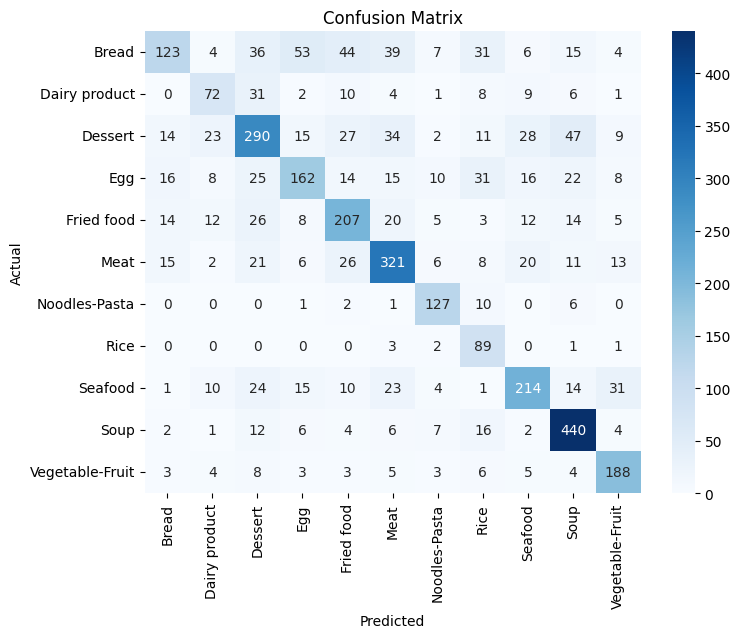

Overall Accuracy: 65.10%
Top-5 Accuracy: 94.78%
Balanced Accuracy: 66.94%

Per-Class Accuracies:
Bread: 33.98%
Dairy product: 50.00%
Dessert: 58.00%
Egg: 49.54%
Fried food: 63.50%
Meat: 71.49%
Noodles-Pasta: 86.39%
Rice: 92.71%
Seafood: 61.67%
Soup: 88.00%
Vegetable-Fruit: 81.03%

Training with Adam optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1.3941 | Training Accuracy: 52.71% | Validation Loss: 1.0292 | Validation Accuracy: 66.34%
Epoch: 2 | Training Loss: 1.0699 | Training Accuracy: 64.00% | Validation Loss: 1.0125 | Validation Accuracy: 65.76%
Epoch: 3 | Training Loss: 0.9692 | Training Accuracy: 66.74% | Validation Loss: 0.9687 | Validation Accuracy: 67.51%
Epoch: 4 | Training Loss: 0.8853 | Training Accuracy: 69.90% | Validation Loss: 0.9607 | Validation Accuracy: 68.45%
Epoch: 5 | Training Loss: 0.8571 | Training Accuracy: 70.30% | Validation Loss: 0.9546 | Validation Accuracy: 68.13%
Epoch: 6 | Training Loss: 0.7939 | Training Accuracy: 73.04% | Validation Loss: 0.9102 | Validation Accuracy: 69.64%


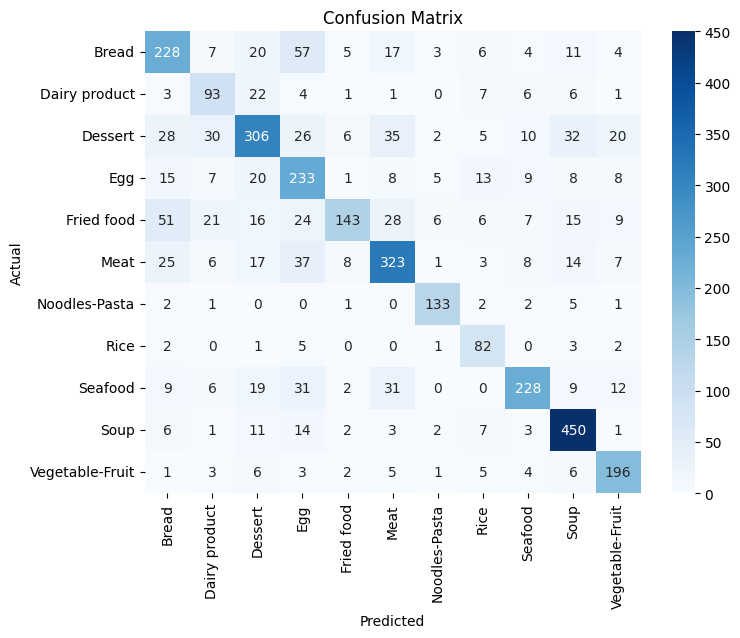

Overall Accuracy: 70.41%
Top-5 Accuracy: 96.36%
Balanced Accuracy: 71.99%

Per-Class Accuracies:
Bread: 62.98%
Dairy product: 64.58%
Dessert: 61.20%
Egg: 71.25%
Fried food: 43.87%
Meat: 71.94%
Noodles-Pasta: 90.48%
Rice: 85.42%
Seafood: 65.71%
Soup: 90.00%
Vegetable-Fruit: 84.48%

Training with RMSprop optimizer and learning-rate of 0.001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 28.0266 | Training Accuracy: 36.18% | Validation Loss: 1.4892 | Validation Accuracy: 52.31%
Epoch: 2 | Training Loss: 1.4740 | Training Accuracy: 50.73% | Validation Loss: 1.2854 | Validation Accuracy: 59.45%
Epoch: 3 | Training Loss: 1.3336 | Training Accuracy: 56.19% | Validation Loss: 1.3788 | Validation Accuracy: 51.98%
Epoch: 4 | Training Loss: 1.2565 | Training Accuracy: 59.56% | Validation Loss: 1.3188 | Validation Accuracy: 54.68%
Epoch: 5 | Training Loss: 1.1925 | Training Accuracy: 60.41% | Validation Loss: 1.1147 | Validation Accuracy: 64.83%
Epoch: 6 | Training Loss: 1.1344 | Training Accuracy: 63.40% | Validation Loss: 1.0890 | Validation Accuracy: 64.37%


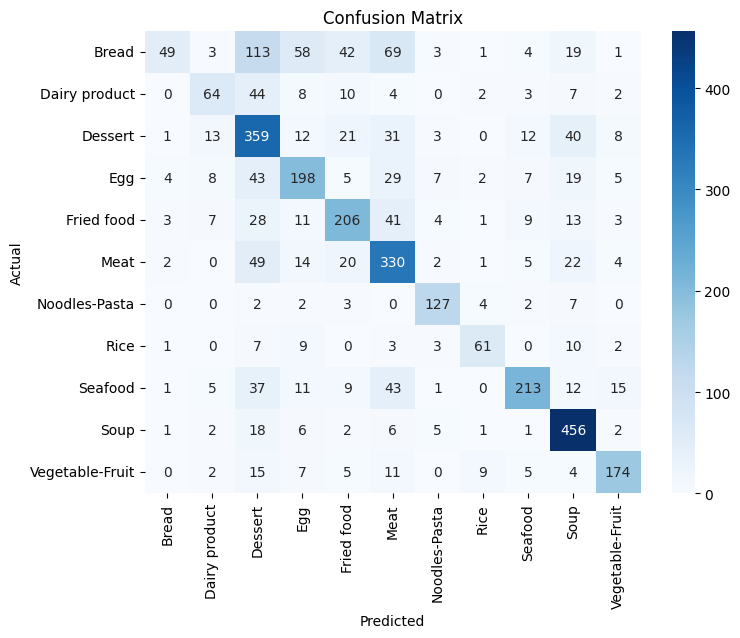

Overall Accuracy: 65.22%
Top-5 Accuracy: 95.63%
Balanced Accuracy: 64.05%

Per-Class Accuracies:
Bread: 13.54%
Dairy product: 44.44%
Dessert: 71.80%
Egg: 60.55%
Fried food: 63.19%
Meat: 73.50%
Noodles-Pasta: 86.39%
Rice: 63.54%
Seafood: 61.38%
Soup: 91.20%
Vegetable-Fruit: 75.00%

Training with RMSprop optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1.8002 | Training Accuracy: 51.39% | Validation Loss: 1.2438 | Validation Accuracy: 56.12%
Epoch: 2 | Training Loss: 1.0609 | Training Accuracy: 63.83% | Validation Loss: 1.0511 | Validation Accuracy: 64.57%
Epoch: 3 | Training Loss: 0.9657 | Training Accuracy: 67.48% | Validation Loss: 1.0724 | Validation Accuracy: 63.32%
Epoch: 4 | Training Loss: 0.9000 | Training Accuracy: 69.47% | Validation Loss: 1.0597 | Validation Accuracy: 65.36%
Epoch: 5 | Training Loss: 0.8462 | Training Accuracy: 71.37% | Validation Loss: 1.0073 | Validation Accuracy: 66.94%
Epoch: 6 | Training Loss: 0.8033 | Training Accuracy: 72.67% | Validation Loss: 0.9222 | Validation Accuracy: 69.86%


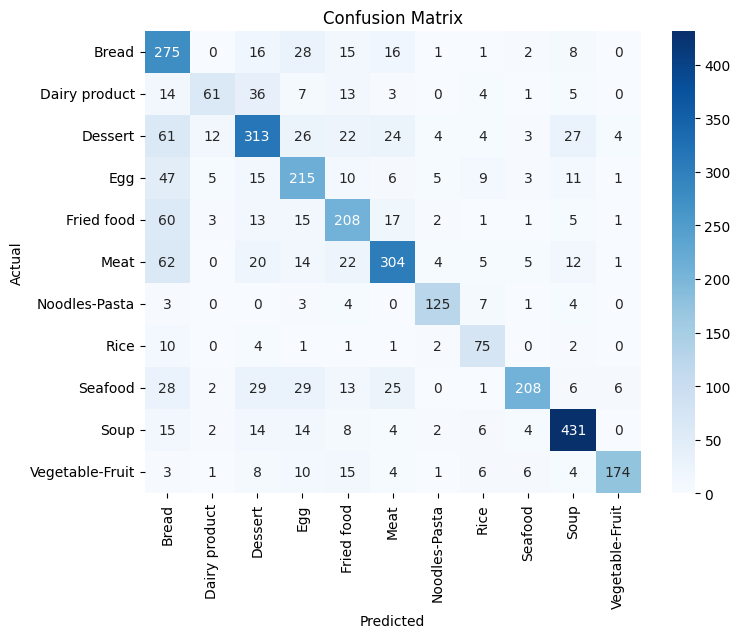

Overall Accuracy: 69.65%
Top-5 Accuracy: 96.18%
Balanced Accuracy: 69.32%

Per-Class Accuracies:
Bread: 75.97%
Dairy product: 42.36%
Dessert: 62.60%
Egg: 65.75%
Fried food: 63.80%
Meat: 67.71%
Noodles-Pasta: 85.03%
Rice: 78.12%
Seafood: 59.94%
Soup: 86.20%
Vegetable-Fruit: 75.00%


In [29]:
for optim in [(torch.optim.Adam,"Adam"),(torch.optim.RMSprop,"RMSprop")]:
    for lr in [0.001,0.0001]:
        print(f"\nTraining with {optim[1]} optimizer and learning-rate of {lr}\n")

        # get pretrained model weights
        weights = torchvision.models.AlexNet_Weights.DEFAULT

        # get pretrained model
        model = torchvision.models.alexnet(weights=weights).to(device)

        # freeze the convolutional layers of the model
        for param in model.features.parameters():
            param.requires_grad = False

        # update the classifier of the model
        # the output size of the layer should be same as the number of classes in the data
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(9216,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,len(train_data.classes))
        ).to(device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimizer
        optimizer = optim[0](model.parameters(), lr=lr)

        results[(optim[1],lr)] = {
            "train_loss": [],
            "val_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
            val_loss,val_acc = test(model,val_dataloader,criterion)

            print(f"Epoch: {epoch+1} | Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}% | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

            # update the results dictionary
            results[(optim[1],lr)]["train_loss"].append(train_loss)
            results[(optim[1],lr)]["val_loss"].append(val_loss)

        # evaluate the model on the validation set
        balanced_accuracy = evaluate(model, val_dataloader, class_names)

        if balanced_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = balanced_accuracy
            best_model = model
            best_optim = optim[1]
            best_lr = lr
            best_model_name = "AlexNet"

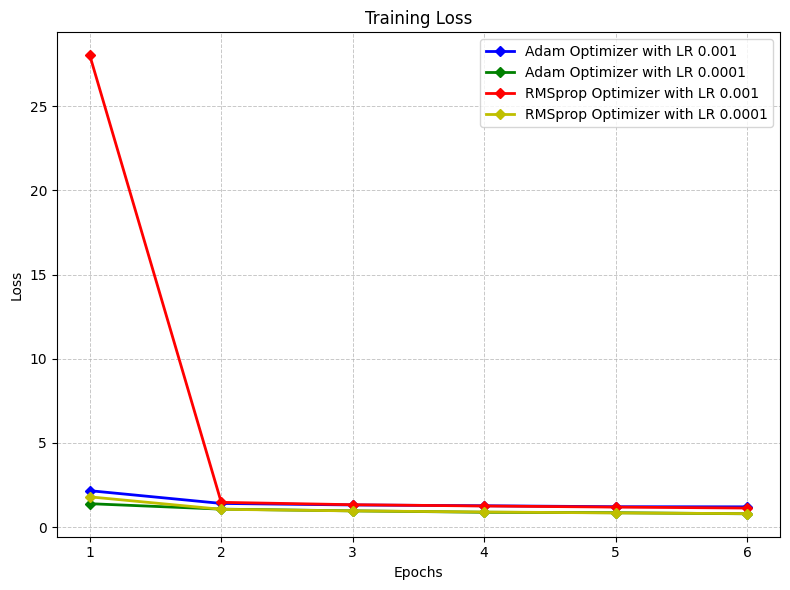

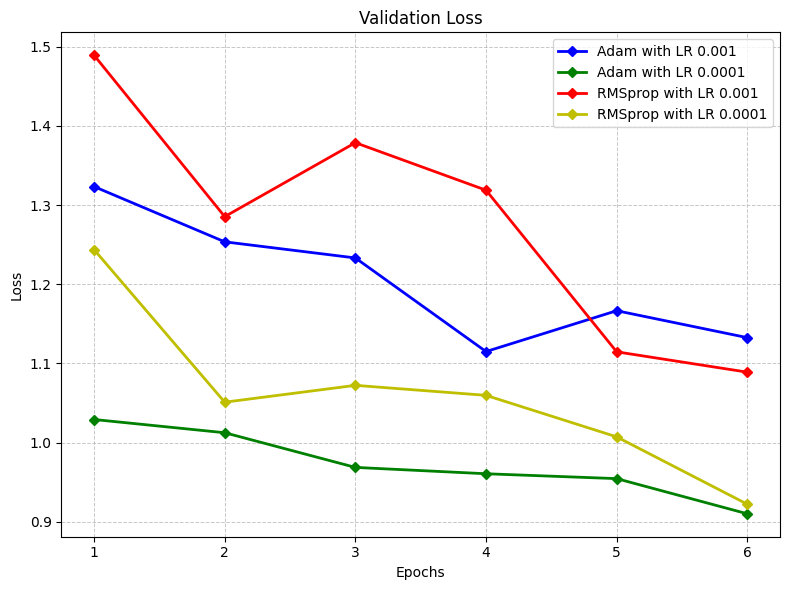

In [30]:
# plot the loss curves
plot_curves(results)

**VGG-16**

In [31]:
epochs = 6

results = {}


Training with Adam optimizer and learning-rate of 0.001



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 150MB/s]


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1.8762 | Training Accuracy: 57.12% | Validation Loss: 0.9147 | Validation Accuracy: 70.67%
Epoch: 2 | Training Loss: 0.9982 | Training Accuracy: 68.70% | Validation Loss: 0.9077 | Validation Accuracy: 71.22%
Epoch: 3 | Training Loss: 0.9531 | Training Accuracy: 70.99% | Validation Loss: 0.8662 | Validation Accuracy: 73.07%
Epoch: 4 | Training Loss: 0.8663 | Training Accuracy: 73.75% | Validation Loss: 0.8335 | Validation Accuracy: 75.19%
Epoch: 5 | Training Loss: 0.8238 | Training Accuracy: 76.11% | Validation Loss: 0.7887 | Validation Accuracy: 76.30%
Epoch: 6 | Training Loss: 0.8169 | Training Accuracy: 76.07% | Validation Loss: 0.8382 | Validation Accuracy: 74.32%


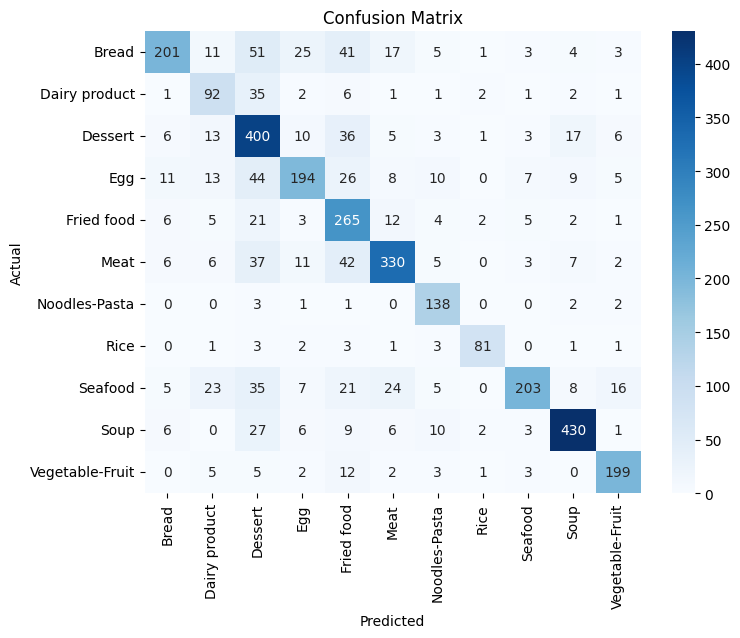

Overall Accuracy: 73.85%
Top-5 Accuracy: 96.33%
Balanced Accuracy: 74.73%

Per-Class Accuracies:
Bread: 55.52%
Dairy product: 63.89%
Dessert: 80.00%
Egg: 59.33%
Fried food: 81.29%
Meat: 73.50%
Noodles-Pasta: 93.88%
Rice: 84.38%
Seafood: 58.50%
Soup: 86.00%
Vegetable-Fruit: 85.78%

Training with Adam optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1.0977 | Training Accuracy: 62.99% | Validation Loss: 0.7810 | Validation Accuracy: 73.80%
Epoch: 2 | Training Loss: 0.6868 | Training Accuracy: 77.37% | Validation Loss: 0.7342 | Validation Accuracy: 75.77%
Epoch: 3 | Training Loss: 0.5534 | Training Accuracy: 81.96% | Validation Loss: 0.7237 | Validation Accuracy: 75.92%
Epoch: 4 | Training Loss: 0.4781 | Training Accuracy: 84.44% | Validation Loss: 0.7291 | Validation Accuracy: 75.99%
Epoch: 5 | Training Loss: 0.4134 | Training Accuracy: 86.48% | Validation Loss: 0.6772 | Validation Accuracy: 78.71%
Epoch: 6 | Training Loss: 0.3839 | Training Accuracy: 87.44% | Validation Loss: 0.7233 | Validation Accuracy: 78.01%


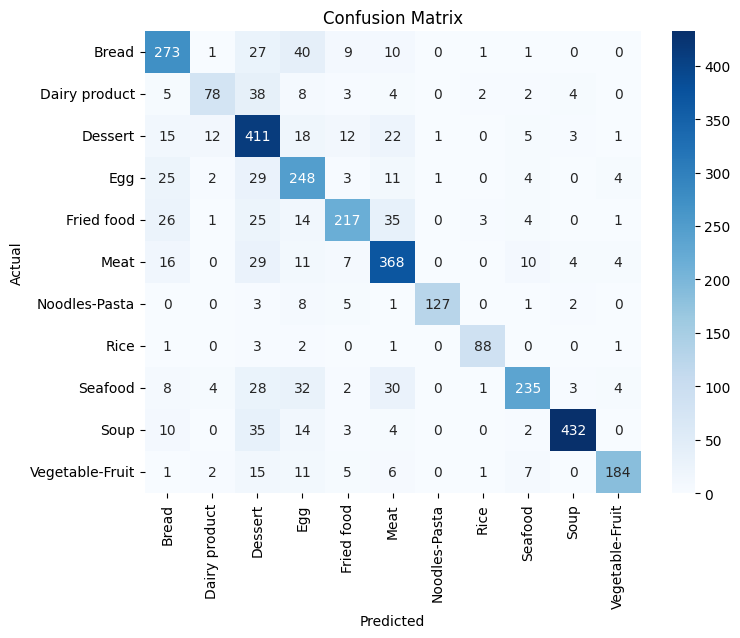

Overall Accuracy: 77.58%
Top-5 Accuracy: 97.96%
Balanced Accuracy: 77.06%

Per-Class Accuracies:
Bread: 75.41%
Dairy product: 54.17%
Dessert: 82.20%
Egg: 75.84%
Fried food: 66.56%
Meat: 81.96%
Noodles-Pasta: 86.39%
Rice: 91.67%
Seafood: 67.72%
Soup: 86.40%
Vegetable-Fruit: 79.31%

Training with RMSprop optimizer and learning-rate of 0.001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 19.2976 | Training Accuracy: 36.47% | Validation Loss: 1.3664 | Validation Accuracy: 58.31%
Epoch: 2 | Training Loss: 1.7410 | Training Accuracy: 50.26% | Validation Loss: 1.2930 | Validation Accuracy: 61.32%
Epoch: 3 | Training Loss: 1.4207 | Training Accuracy: 58.32% | Validation Loss: 1.0750 | Validation Accuracy: 65.08%
Epoch: 4 | Training Loss: 1.3573 | Training Accuracy: 63.00% | Validation Loss: 0.9254 | Validation Accuracy: 71.87%
Epoch: 5 | Training Loss: 1.1518 | Training Accuracy: 66.96% | Validation Loss: 0.9216 | Validation Accuracy: 72.63%
Epoch: 6 | Training Loss: 1.1108 | Training Accuracy: 68.71% | Validation Loss: 1.0452 | Validation Accuracy: 69.82%


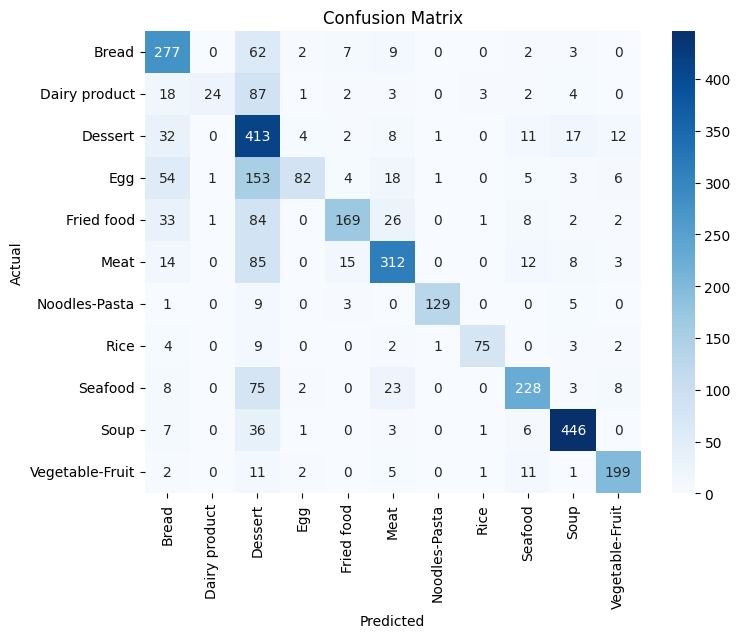

Overall Accuracy: 68.63%
Top-5 Accuracy: 92.22%
Balanced Accuracy: 66.25%

Per-Class Accuracies:
Bread: 76.52%
Dairy product: 16.67%
Dessert: 82.60%
Egg: 25.08%
Fried food: 51.84%
Meat: 69.49%
Noodles-Pasta: 87.76%
Rice: 78.12%
Seafood: 65.71%
Soup: 89.20%
Vegetable-Fruit: 85.78%

Training with RMSprop optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1.2981 | Training Accuracy: 63.11% | Validation Loss: 0.8422 | Validation Accuracy: 71.20%
Epoch: 2 | Training Loss: 0.6949 | Training Accuracy: 76.68% | Validation Loss: 1.0262 | Validation Accuracy: 68.15%
Epoch: 3 | Training Loss: 0.5585 | Training Accuracy: 81.46% | Validation Loss: 0.6982 | Validation Accuracy: 76.98%
Epoch: 4 | Training Loss: 0.4741 | Training Accuracy: 84.66% | Validation Loss: 0.7790 | Validation Accuracy: 74.97%
Epoch: 5 | Training Loss: 0.4312 | Training Accuracy: 86.18% | Validation Loss: 0.7803 | Validation Accuracy: 75.73%
Epoch: 6 | Training Loss: 0.3884 | Training Accuracy: 87.55% | Validation Loss: 0.6836 | Validation Accuracy: 78.83%


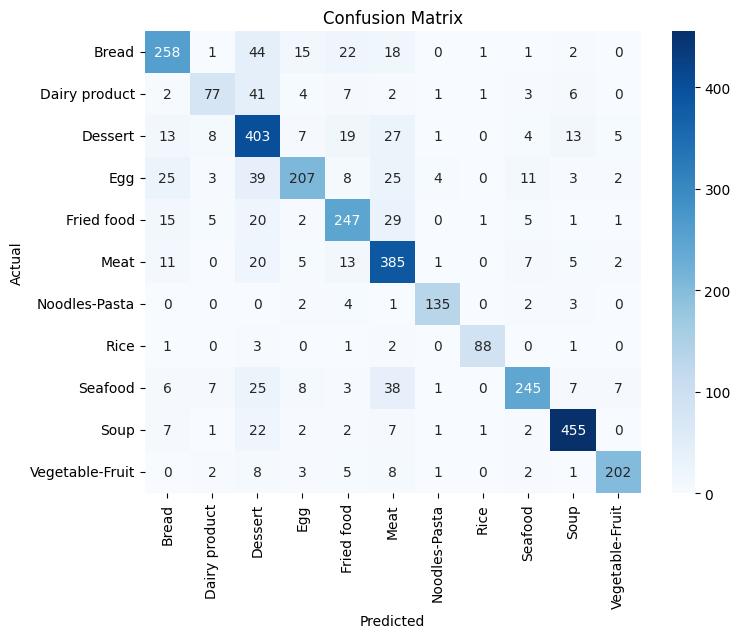

Overall Accuracy: 78.78%
Top-5 Accuracy: 97.81%
Balanced Accuracy: 78.39%

Per-Class Accuracies:
Bread: 71.27%
Dairy product: 53.47%
Dessert: 80.60%
Egg: 63.30%
Fried food: 75.77%
Meat: 85.75%
Noodles-Pasta: 91.84%
Rice: 91.67%
Seafood: 70.61%
Soup: 91.00%
Vegetable-Fruit: 87.07%


In [32]:
for optim in [(torch.optim.Adam,"Adam"),(torch.optim.RMSprop,"RMSprop")]:
    for lr in [0.001,0.0001]:
        print(f"\nTraining with {optim[1]} optimizer and learning-rate of {lr}\n")

        # get pretrained model weights
        weights = torchvision.models.VGG16_Weights.DEFAULT

        # get pretrained model
        model = torchvision.models.vgg16(weights=weights).to(device)

        # freeze the convolutional layers of the model
        for param in model.features.parameters():
            param.requires_grad = False

        # update the classifier of the model
        # the output size of the layer should be same as the number of classes in the data
        model.classifier = nn.Sequential(
            nn.Linear(25088,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(4096,len(train_data.classes))
        ).to(device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimizer
        optimizer = optim[0](model.parameters(), lr=lr)

        results[(optim[1],lr)] = {
            "train_loss": [],
            "val_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
            val_loss,val_acc = test(model,val_dataloader,criterion)

            print(f"Epoch: {epoch+1} | Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}% | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

            # update the results dictionary
            results[(optim[1],lr)]["train_loss"].append(train_loss)
            results[(optim[1],lr)]["val_loss"].append(val_loss)

        # evaluate the model on the validation set
        balanced_accuracy = evaluate(model, val_dataloader, class_names)

        if balanced_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = balanced_accuracy
            best_model = model
            best_optim = optim[1]
            best_lr = lr
            best_model_name = "VGG-16"

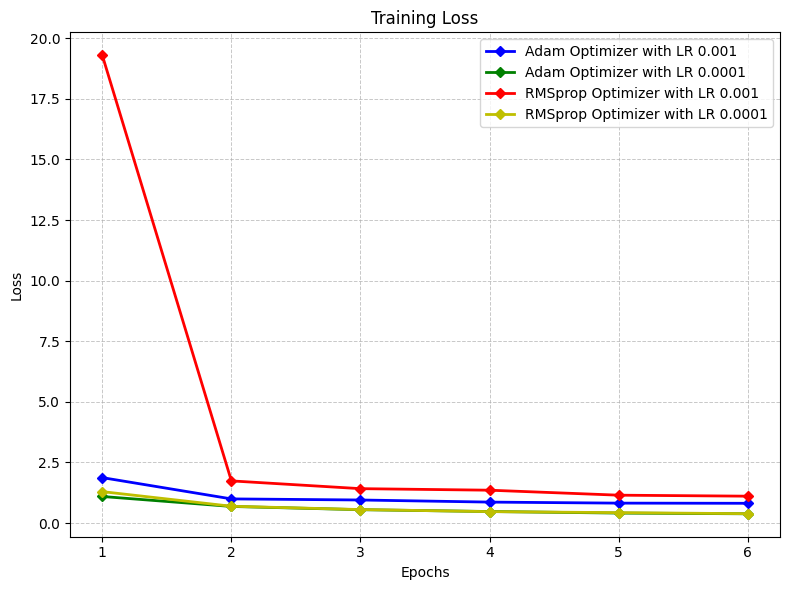

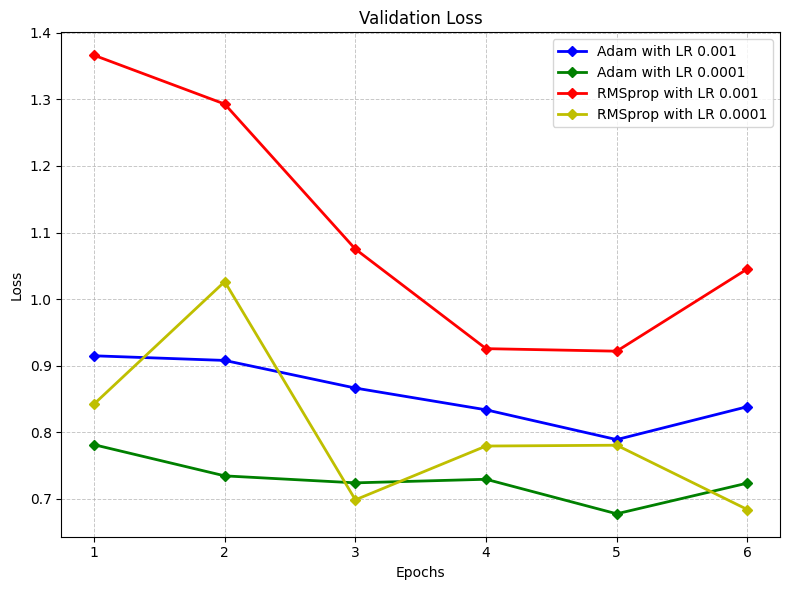

In [33]:
# plot the loss curves
plot_curves(results)

**RESNET-18**

In [34]:
epochs = 6

results = {}

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



Training with Adam optimizer and learning-rate of 0.001



100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1.5058 | Training Accuracy: 52.76% | Validation Loss: 1.1098 | Validation Accuracy: 66.40%
Epoch: 2 | Training Loss: 1.0049 | Training Accuracy: 68.48% | Validation Loss: 0.9503 | Validation Accuracy: 69.54%
Epoch: 3 | Training Loss: 0.8913 | Training Accuracy: 71.42% | Validation Loss: 0.8895 | Validation Accuracy: 71.71%
Epoch: 4 | Training Loss: 0.8434 | Training Accuracy: 72.72% | Validation Loss: 0.8774 | Validation Accuracy: 71.07%
Epoch: 5 | Training Loss: 0.8144 | Training Accuracy: 73.10% | Validation Loss: 0.8546 | Validation Accuracy: 71.28%
Epoch: 6 | Training Loss: 0.8012 | Training Accuracy: 73.37% | Validation Loss: 0.8471 | Validation Accuracy: 72.30%


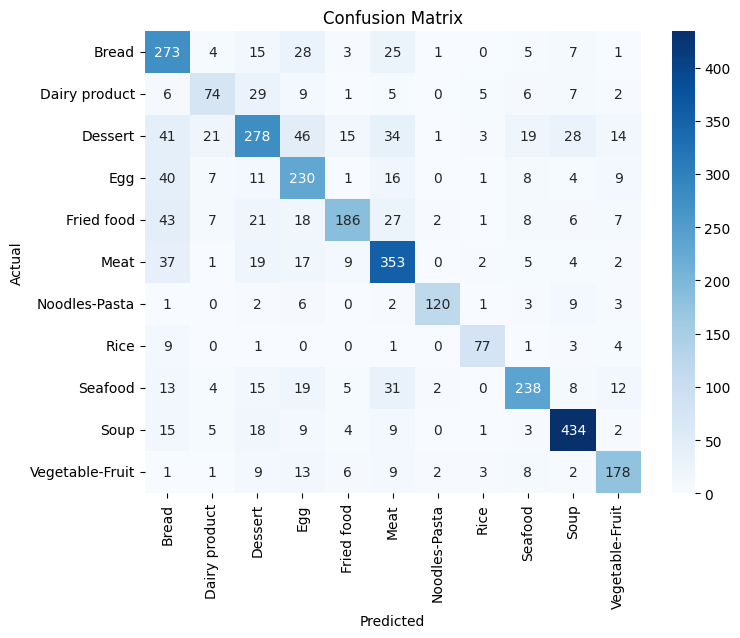

Overall Accuracy: 71.17%
Top-5 Accuracy: 96.88%
Balanced Accuracy: 71.12%

Per-Class Accuracies:
Bread: 75.41%
Dairy product: 51.39%
Dessert: 55.60%
Egg: 70.34%
Fried food: 57.06%
Meat: 78.62%
Noodles-Pasta: 81.63%
Rice: 80.21%
Seafood: 68.59%
Soup: 86.80%
Vegetable-Fruit: 76.72%

Training with Adam optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 2.1389 | Training Accuracy: 26.80% | Validation Loss: 1.9757 | Validation Accuracy: 33.83%
Epoch: 2 | Training Loss: 1.8258 | Training Accuracy: 41.78% | Validation Loss: 1.6973 | Validation Accuracy: 46.04%
Epoch: 3 | Training Loss: 1.5998 | Training Accuracy: 51.71% | Validation Loss: 1.5231 | Validation Accuracy: 53.77%
Epoch: 4 | Training Loss: 1.4472 | Training Accuracy: 57.25% | Validation Loss: 1.4023 | Validation Accuracy: 58.08%
Epoch: 5 | Training Loss: 1.3390 | Training Accuracy: 61.49% | Validation Loss: 1.3093 | Validation Accuracy: 61.66%
Epoch: 6 | Training Loss: 1.2586 | Training Accuracy: 63.43% | Validation Loss: 1.2266 | Validation Accuracy: 64.05%


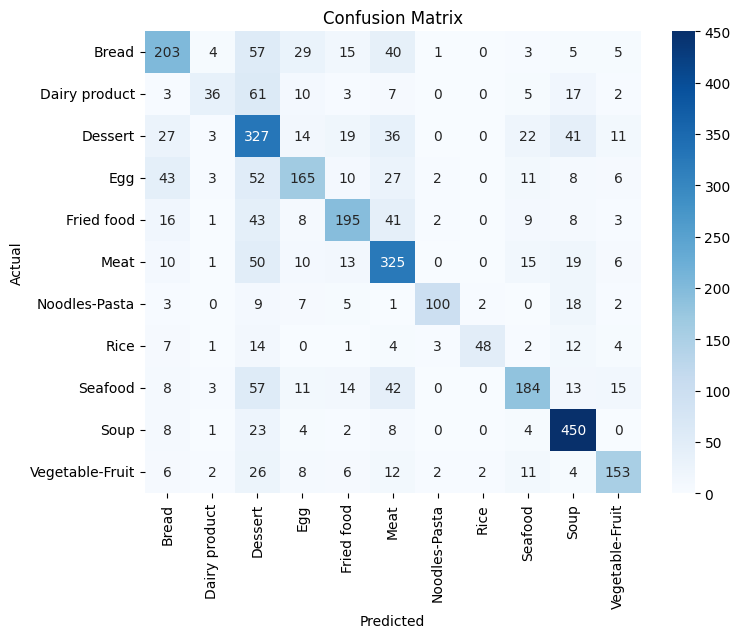

Overall Accuracy: 63.73%
Top-5 Accuracy: 93.88%
Balanced Accuracy: 59.65%

Per-Class Accuracies:
Bread: 56.08%
Dairy product: 25.00%
Dessert: 65.40%
Egg: 50.46%
Fried food: 59.82%
Meat: 72.38%
Noodles-Pasta: 68.03%
Rice: 50.00%
Seafood: 53.03%
Soup: 90.00%
Vegetable-Fruit: 65.95%

Training with RMSprop optimizer and learning-rate of 0.001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1.4016 | Training Accuracy: 55.17% | Validation Loss: 1.1860 | Validation Accuracy: 59.96%
Epoch: 2 | Training Loss: 0.9817 | Training Accuracy: 68.48% | Validation Loss: 1.1695 | Validation Accuracy: 58.11%
Epoch: 3 | Training Loss: 0.8987 | Training Accuracy: 70.57% | Validation Loss: 1.0171 | Validation Accuracy: 66.73%
Epoch: 4 | Training Loss: 0.8453 | Training Accuracy: 72.28% | Validation Loss: 0.8971 | Validation Accuracy: 70.41%
Epoch: 5 | Training Loss: 0.8233 | Training Accuracy: 73.07% | Validation Loss: 0.9580 | Validation Accuracy: 67.28%
Epoch: 6 | Training Loss: 0.7837 | Training Accuracy: 74.07% | Validation Loss: 0.8863 | Validation Accuracy: 71.41%


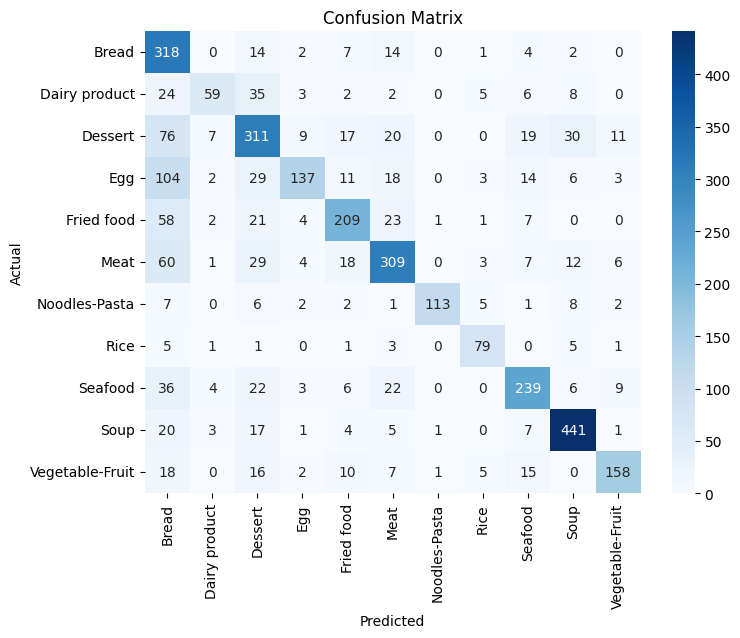

Overall Accuracy: 69.18%
Top-5 Accuracy: 96.53%
Balanced Accuracy: 68.20%

Per-Class Accuracies:
Bread: 87.85%
Dairy product: 40.97%
Dessert: 62.20%
Egg: 41.90%
Fried food: 64.11%
Meat: 68.82%
Noodles-Pasta: 76.87%
Rice: 82.29%
Seafood: 68.88%
Soup: 88.20%
Vegetable-Fruit: 68.10%

Training with RMSprop optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 2.0125 | Training Accuracy: 31.54% | Validation Loss: 1.8053 | Validation Accuracy: 40.29%
Epoch: 2 | Training Loss: 1.6761 | Training Accuracy: 47.82% | Validation Loss: 1.5739 | Validation Accuracy: 52.60%
Epoch: 3 | Training Loss: 1.4986 | Training Accuracy: 55.08% | Validation Loss: 1.4357 | Validation Accuracy: 58.42%
Epoch: 4 | Training Loss: 1.3715 | Training Accuracy: 59.52% | Validation Loss: 1.3170 | Validation Accuracy: 60.54%
Epoch: 5 | Training Loss: 1.2848 | Training Accuracy: 61.86% | Validation Loss: 1.2407 | Validation Accuracy: 63.13%
Epoch: 6 | Training Loss: 1.2123 | Training Accuracy: 64.67% | Validation Loss: 1.1928 | Validation Accuracy: 64.38%


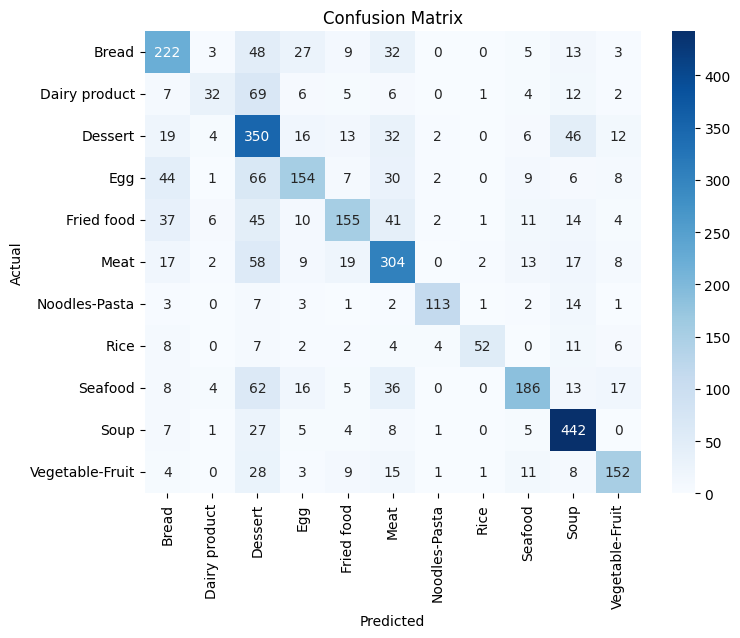

Overall Accuracy: 63.03%
Top-5 Accuracy: 94.46%
Balanced Accuracy: 59.50%

Per-Class Accuracies:
Bread: 61.33%
Dairy product: 22.22%
Dessert: 70.00%
Egg: 47.09%
Fried food: 47.55%
Meat: 67.71%
Noodles-Pasta: 76.87%
Rice: 54.17%
Seafood: 53.60%
Soup: 88.40%
Vegetable-Fruit: 65.52%


In [35]:
for optim in [(torch.optim.Adam,"Adam"),(torch.optim.RMSprop,"RMSprop")]:
    for lr in [0.001,0.0001]:
        print(f"\nTraining with {optim[1]} optimizer and learning-rate of {lr}\n")

        # get pretrained model weights
        weights = torchvision.models.ResNet18_Weights.DEFAULT

        # get pretrained model
        model = torchvision.models.resnet18(weights=weights).to(device)

        # freeze the convolutional layers of the model
        for param in model.parameters():
            param.requires_grad = False

        # update the classifier of the model
        # the output size of the layer should be same as the number of classes in the data
        model.fc = nn.Linear(512,len(train_data.classes)).to(device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimizer
        optimizer = optim[0](model.parameters(), lr=lr)

        results[(optim[1],lr)] = {
            "train_loss": [],
            "val_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
            val_loss,val_acc = test(model,val_dataloader,criterion)

            print(f"Epoch: {epoch+1} | Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}% | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

            # update the results dictionary
            results[(optim[1],lr)]["train_loss"].append(train_loss)
            results[(optim[1],lr)]["val_loss"].append(val_loss)

        # evaluate the model on the validation set
        balanced_accuracy = evaluate(model, val_dataloader, class_names)

        if balanced_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = balanced_accuracy
            best_model = model
            best_optim = optim[1]
            best_lr = lr
            best_model_name = "ResNet-18"

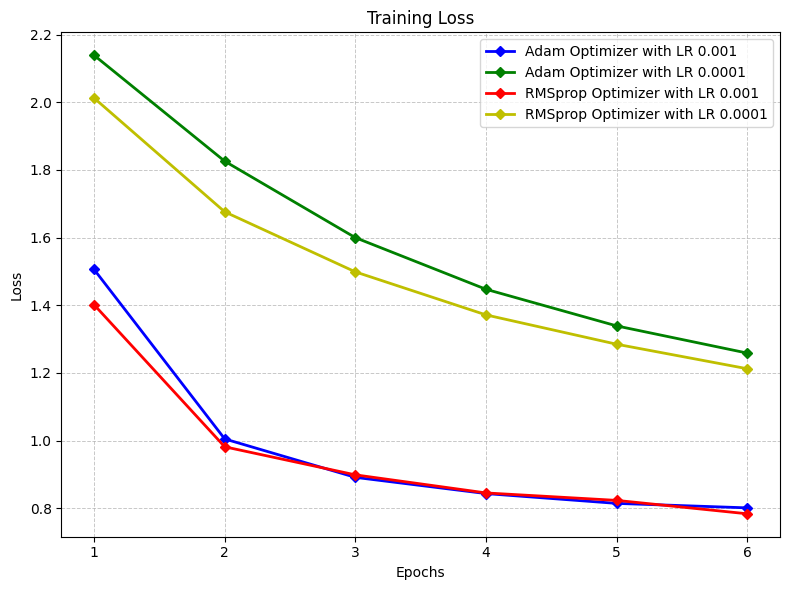

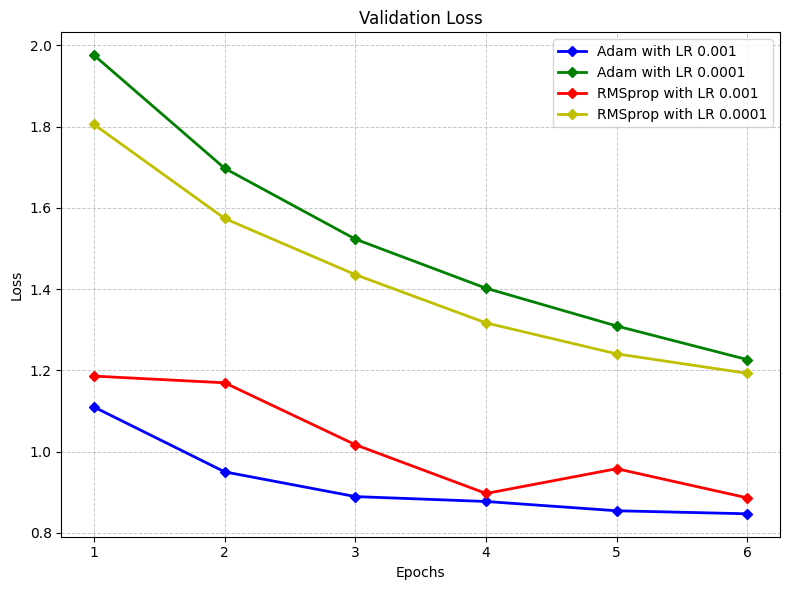

In [36]:
# plot the loss curves
plot_curves(results)

**TESTING THE BEST MODEL**

In [37]:
print(f"Best performing model is {best_model_name} with {best_optim} optimizer and learning-rate {best_lr}")

Best performing model is VGG-16 with RMSprop optimizer and learning-rate 0.0001


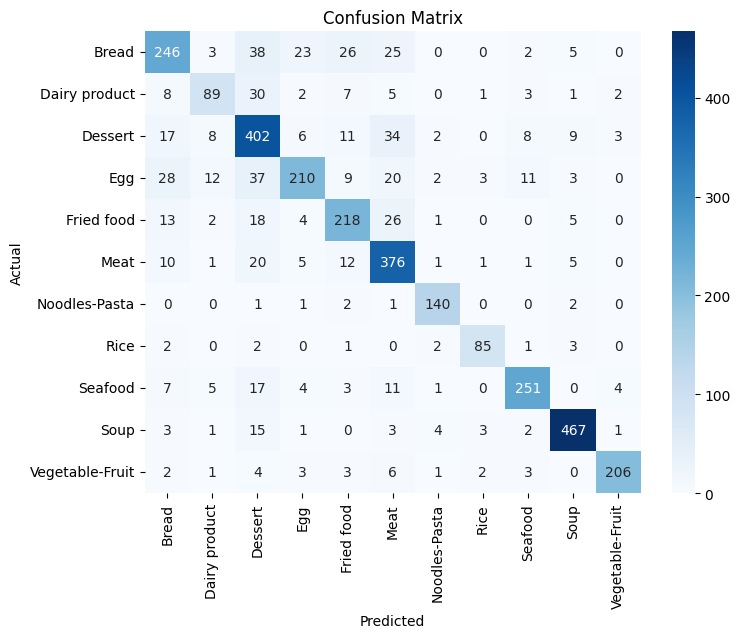

Overall Accuracy: 80.37%
Top-5 Accuracy: 98.30%
Balanced Accuracy: 80.21%

Per-Class Accuracies:
Bread: 66.85%
Dairy product: 60.14%
Dessert: 80.40%
Egg: 62.69%
Fried food: 75.96%
Meat: 87.04%
Noodles-Pasta: 95.24%
Rice: 88.54%
Seafood: 82.84%
Soup: 93.40%
Vegetable-Fruit: 89.18%


0.8020548077156835

In [38]:
# evaluate the best model on the test set
evaluate(best_model, test_dataloader, class_names)